[-2.13504428e-18 -4.24765060e-01 -6.66205675e-18 -5.82243921e-02
 -2.17566426e-17  7.45649316e-01  2.34611021e-17 -3.15042260e-01
 -4.17044767e-17  5.82477683e-02  9.11412196e-18 -6.29565048e-03
  8.14674894e-18  4.52771175e-04  2.22201773e-17 -2.33768866e-05
  1.52932061e-17  9.11617199e-07  4.72844986e-19 -2.78529108e-08
  2.98718114e-18  6.85569893e-10  1.59024137e-17 -1.38959482e-11
  9.31162866e-18  2.36037403e-13 -4.44800891e-20 -3.39538578e-15
  2.13504428e-18 -3.42857215e-17  1.13869028e-17  4.82198622e-17
  0.00000000e+00  2.05651547e-16  9.10952225e-17 -1.60631912e-17
  5.69345141e-18 -1.73907192e-16  0.00000000e+00 -2.63322128e-17]


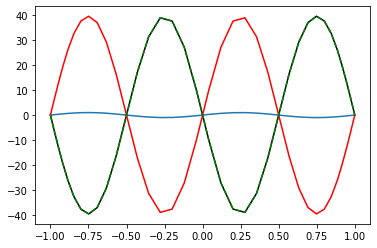

In [88]:
#https://mikaem.github.io/shenfun-demos/content/poisson.html#shen1
import numpy as np 
import matplotlib.pyplot as plt
from pypde.bases.dmsuite import *
from scipy.fftpack import dctn
from pypde.bases.chebyshev import *
from pypde.bases.inner import *
from scipy.sparse import diags
from scipy.sparse.linalg import inv

def f(x,m=1):
    arg = 2*np.pi/2*m
    return np.sin(arg*x)#+np.cos(arg*x)

def df(x,m=1):
    arg = 2*np.pi/2*m
    return -arg**2*np.sin(arg*x)#+np.cos(arg*x)

def pm(M):
    np.set_printoptions(formatter={'float': "{: 4.2f}\t".format})
    print(M)
    np.set_printoptions()

class ChebDirichlet(Spectralbase):
    """
    Function space for Dirichlet boundary conditions
    .. math::
        \phi_k = T_k - T_{k+2}
    
    Parameters:
        N: int
            Number of grid points
        bc: 2-tuple of floats, optional
            Boundary conditions at, respectively, x=(-1, 1).
            
    """
    def __init__(self,N,bc=(0,0)):
        Spectralbase.__init__(self,N)
        
        #self.bc = BoundaryValues(self, bc=bc) # TODO

    def eval(self,c):
        ''' 
        Evaluate f(x) from spectral coefficients c 
        '''
        y = np.zeros(self.N) 
        for i in range(self.N):
            y += c[i]*self.get_basis(i)
        return y
            
    def get_basis(self, i=0, x=None):
        if x is None: x = self.x
        if i < self.N-2:
            w = np.arccos(x)
            return np.cos(i*w) - np.cos((i+2)*w)
        elif i == self.N-2:
            return 0.5*(1-x)
        elif i == self.N-1:
            return 0.5*(1+x)
    
    def _mass(self):
        ''' 
        Eq. (2.5) of Shen - Effcient Spectral-Galerkin Method II.
        '''
        diag0 = [1.5, *[1.0]*(self.N-4), 1.5]
        diag2 = [*[-0.5]*(self.N-4) ]
        return diags([diag2, diag0, diag2], [-2, 0, 2],format="csc")
    
    def _mass_inv(self):
        return inv(self._mass())

    def slice(self):
        ''' 
        Chebdirichlet space defined for [0,N-3] bases + 2 BCs
        '''
        return slice(0, self.N-2)

    def forward_fft(self,f):
        '''  
        Transform to spectral space via DCT 
        '''
        c = Chebyshev.forward_fft(self,f,nomass=True)
        c = self._map(c)
        c[self.slice()] = self._mass_inv()@c[self.slice()]
        c[ [-2,-1] ] = 0 # BCs
        return c
    
    def backward_fft(self,c):
        '''  
        Transform to physical space via DCT 
        ''' 
        c = self._map(c,inv=True)
        return Chebyshev.backward_fft(self,c)
    
    @property
    def _s0(self):
        return slice(0, self.N-2)
    
    @property
    def _s1(self):
        return slice(2, self.N)
    
    def derivative(self,f,deriv,method="fft"):
        ''' 
        Calculate derivative of input array f 
        '''
        if method in ("fft", "spectral"):
            c = self.forward_fft(f)
            S = -stencil(self.N,diag=-2)
            Si = np.linalg.inv(S)
            pm(Si)
            #c = self._map(c,True)
            
            #dc = diffmat_spectral(self.N,deriv)@c
            #print(Si)
            #dc = Si@dc 
            D2 = -diffmat_spectral(self.N,deriv)@S
            print(D2)
            #D2 = Si@diffmat_spectral(self.N,deriv)@S
            dc = D2@c
            print(D2)
            print( diffmat_spectral(self.N,deriv) )
            return Chebyshev.backward_fft(self,dc)
        
        elif method in ("fft2", "spectral"):
            c = self.forward_fft(f)
            S = -stencil(self.N,diag=-2)
            Si = np.linalg.inv(S)
            #pm(Si)
            D2 = diffmat_spectral(self.N,deriv)@S
            dc = D2@c
            #pm(Si@D2@S)
            dc = Chebyshev.backward_fft(self,dc)
            #dc = Si@dc
            return dc
        
        elif method in ("dm", "physical"):
            return self.get_deriv_mat(deriv)@f
        else: 
            raise NotImplementedError("Not implemented method: {:s}".format(method))
    
    def _map(self,c,inv=False):
        ''' 
        Map from Galerkin to Chebshev representation.
        K. Julien: doi:10.1016/j.jcp.2008.10.043 
        '''
        _c = c; 
        if inv:
            _c[self._s1] -= _c[self._s0]
        else:
            _c[self._s0] -= _c[self._s1]
        return _c
    
    @memoized
    def get_deriv_mat(self,deriv):
        D = chebdif(self.N,deriv)[1]
        I = np.eye(self.N)
        D[:,[0,-1]] = I[:,[0,-1]] # replace row for dirichlet bcs
        return D

def stencil(N,diag=2):
    ''' 
    Stencil Matrix to transform from Chebshev to Galerking representation.
    K. Julien: doi:10.1016/j.jcp.2008.10.043 
    '''
    d0 = [1]*N
    d1 = [-1]*(N-abs(2))
    return diags([d0,d1], [0,diag],format="csc").toarray()

N = 40
CD = ChebDirichlet(N)
CD1 = Chebyshev(N)
x = CD.x
u = f(x,2)#CD.get_basis(i=2)
ud = df(x,2)

du = CD.derivative(u,2,method="fft2")
#fhat = CD.project(u)
#pm(fhat)
#fhat = CD.forward_fft(u)
#pm(fhat)

#f = CD.backward_fft(fhat)
#pm(u)
#pm(f)
plt.plot(x,u)
plt.plot(x,ud,"k")
plt.plot(x,du,"r-")
plt.plot(x,CD1.derivative(u,2),"g--")
plt.show()

In [4]:
76/12

6.333333333333333

In [125]:
import scipy
import scipy.linalg

MI = CD._mass()
#pm( MI.toarray() )

MI = CD._mass_inv()
pm( MI.toarray()  )

#P, L, U = scipy.linalg.lu(MI)

#pm(U)

[[ 0.75	  0.00	  0.25	]
 [ 0.00	  1.00	  0.00	]
 [ 0.25	  0.00	  0.75	]]


In [31]:
s = sparse.diags([0.5, *[1.0]*2, 0.5],0)
out = s@s
out.__dict__

{'_shape': (4, 4),
 'maxprint': 50,
 'indices': array([0, 1, 2, 3], dtype=int32),
 'indptr': array([0, 1, 2, 3, 4], dtype=int32),
 'data': array([0.25, 1.  , 1.  , 0.25])}

In [7]:
import numpy as np
A = [[1,2,3],[4,5,6],[7,8,9]]
A = np.array(A)
Ah = np.vstack(A)
Av = np.hstack(A)
print(Ah)
Ah.shape

[[1 2 3]
 [4 5 6]
 [7 8 9]]


(3, 3)

In [2]:
sl = slice(0,4)
for i in range(10)[sl]:
    print(i)

0
1
2
3


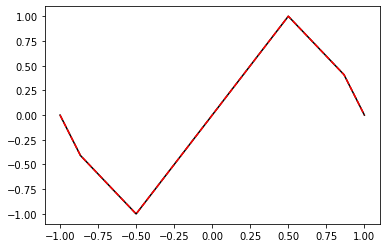

In [2]:
N = 7
CD = ChebDirichlet(N)
x = CD.x

def fun(x):
    return np.sin(2*np.pi/2*x)

c = CD.project_via_mass(fun(x))
y = CD.eval(c)
plt.plot(x,fun(x),"k")
plt.plot(x,y,"r--")
plt.show()

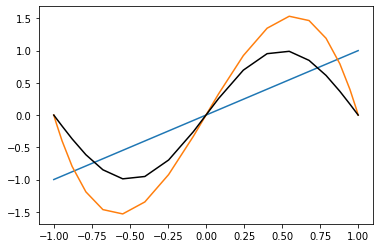

In [6]:

from shenfun import *
N = 20
D0 = FunctionSpace(N, 'C', basis='Orthogonal'   ,quad="GL")
DS = FunctionSpace(N, 'C', basis='ShenDirichlet',quad="GL")
x = D0.mesh()
plt.plot(x,D0.evaluate_basis(x,i=1))
plt.plot(x,DS.evaluate_basis(x,i=1))
plt.plot(x,fun(x),"k")
plt.show()


c = project(fun(x), D0)